## Name: 
Xiaojing Shen/xshen16@depaul.edu  
Serena Yang/myang43@depaul.edu  
Yue Hou/yhou14@depaul.edu
### Group 3 _ Check point 1: EDA & Sentiment Analysis


In [1]:
# import packages in general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import math
import nltk

In [2]:
#if you don't have this package in your system
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/serenayang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
#if you don't have this package in your system
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serenayang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### if you are using Google Drive way to open this file

In [4]:
#open file in Google drive
from google.colab import drive
drive.mount('/content/drive')

#### if you are using Jupyter Notebook

In [5]:
dataset = pd.read_csv('/Users/serenayang/Desktop/Group 3_Capstone Project/data/IMDB Dataset.csv')

### EDA

In [6]:
#EDA
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [8]:
#check missing value
#dataset.isnull().values.any()
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

In [9]:
df = dataset
df['text_length'] = df['review'].apply(len)
df[['review','text_length','sentiment']].head()

,review,text_length,sentiment
0,One of the other reviewers has mentioned that ...,1761,positive
1,A wonderful little production. <br /><br />The...,998,positive
2,I thought this was a wonderful way to spend ti...,926,positive
3,Basically there's a family where a little boy ...,748,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",1317,positive


In [10]:
df['text_length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: text_length, dtype: float64

<AxesSubplot:>

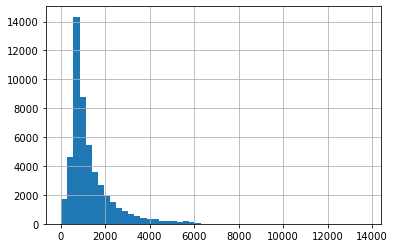

In [11]:
df['text_length'].hist(bins=50)

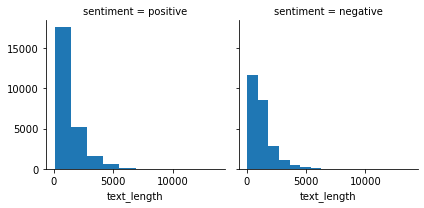

In [12]:
import seaborn as sns
g = sns.FacetGrid(df,col='sentiment')
g.map(plt.hist,'text_length')

In [13]:
#check missing value
df.isnull().sum() 

review         0
sentiment      0
text_length    0
dtype: int64

In [14]:
df.duplicated().sum()

418

In [15]:
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

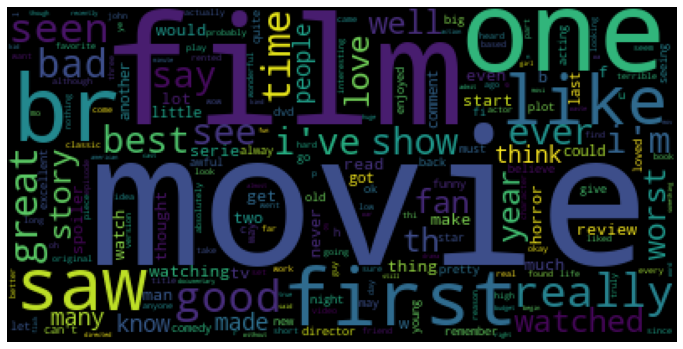

In [16]:
# word cloud
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_review'] = df['review'].apply(clean_text)

text = df['clean_review'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Convert sentiment label to 0,1

In [17]:
target = dataset['sentiment']
reviews = dataset[['clean_review']]
reviews.head()

,clean_review
0,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is..."


In [18]:
target.head()

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [19]:
target = target.replace("positive", 1)
target = target.replace("negative", 0)
target.head()

0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64

In [20]:
target.value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

/Users/serenayang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

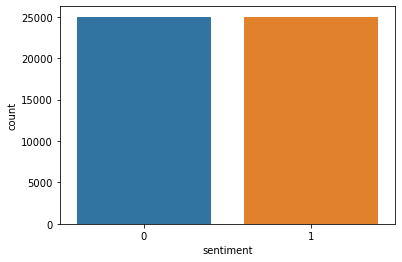

In [21]:
sns.countplot(target)

### Split dataset into training and testing

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(reviews[['clean_review']], target, test_size=0.2, random_state=42, stratify = target)

In [23]:
print('X_train shape:')
print(X_train.shape)
print('X_test shape:')
print(X_test.shape)

X_train shape:
(40000, 1)
X_test shape:
(10000, 1)


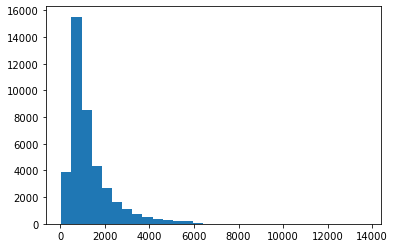

In [24]:
totalNumWords = [len(one_comment) for one_comment in X_train['clean_review']]
plt.hist(totalNumWords,bins = 30)
plt.show()

### GloVe

In [25]:
embeddings_dict = {}
with open('/Users/serenayang/Desktop/Group 3_Capstone Project/data/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [26]:
def encode_document(tokens):
    encoded = np.zeros(100)
    doclen = 0
    for word in tokens:
        if word.lower() in embeddings_dict:
            encoded += np.array(embeddings_dict[word.lower()])
            doclen += 1
    return encoded / doclen

In [27]:
def get_vector(df, column):
    result = []
    for text in df[column]:
        if len(text) > 0:
            tokens = nltk.tokenize.word_tokenize(text)
            enc = encode_document(tokens)
        else:
            enc = np.zeros(100)
        result.append(enc)
    return result

In [28]:
X_train_glove = get_vector(X_train, "clean_review")

In [29]:
X_test_glove = get_vector(X_test, "clean_review")

In [30]:
my_array = np.array(X_train_glove[0])

In [31]:
len(X_train_glove)

40000

In [32]:
def convert_one_vector(embedding_lst):
    new_array= np.zeros((len(embedding_lst), 100))
    for i in range(len(embedding_lst)):
        my_array = np.array(embedding_lst[i])
        new_array[i] = my_array
    return new_array

In [33]:
X_train_glove_1 = convert_one_vector(X_train_glove)
X_train_glove_1.shape

(40000, 100)

In [34]:
X_test_glove_1 = convert_one_vector(X_test_glove)
X_test_glove_1.shape

(10000, 100)

In [35]:
X_train_glove = pd.DataFrame(X_train_glove_1)
X_test_glove = pd.DataFrame(X_test_glove_1)

In [36]:
X_test_glove.shape

(10000, 100)

### DNN

In [37]:
#import sys
#!{sys.executable} -m pip install keras

In [38]:
#import sys
#!{sys.executable} -m pip install tensorflow

In [39]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Activation, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn.metrics import mean_squared_error
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
import keras.backend as K

In [40]:
input_dim=X_train_glove.shape[1]
model_DNN_GloVe = Sequential()
model_DNN_GloVe.add(Dense(200, input_dim=input_dim, activation='relu'))
model_DNN_GloVe.add(Dropout(0.2))
model_DNN_GloVe.add(Dense(100, activation='relu'))
model_DNN_GloVe.add(Dropout(0.2))
model_DNN_GloVe.add(Dense(100, activation='relu'))
model_DNN_GloVe.add(Dropout(0.2))
model_DNN_GloVe.add(Dense(1))
model_DNN_GloVe.add(Activation('sigmoid'))
#model.add(Dense(2, activation='softmax'))
model_DNN_GloVe.add(Dense(1, activation='sigmoid'))
# compile the model
model_DNN_GloVe.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC'])

In [41]:
model_DNN_GloVe.fit(X_train_glove, y_train, batch_size=64, 
          epochs=20, verbose=1, 
          validation_data=(X_test_glove, y_test))

Epoch 1/20
625/625 [==============================] - 2s 2ms/step - loss: 0.6295 - accuracy: 0.6731 - auc: 0.7358 - val_loss: 0.5718 - val_accuracy: 0.7554 - val_auc: 0.8331
Epoch 2/20
625/625 [==============================] - 1s 1ms/step - loss: 0.5577 - accuracy: 0.7576 - auc: 0.8160 - val_loss: 0.5564 - val_accuracy: 0.7419 - val_auc: 0.8428
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 0.5281 - accuracy: 0.7704 - auc: 0.8376 - val_loss: 0.5101 - val_accuracy: 0.7836 - val_auc: 0.8591
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.5114 - accuracy: 0.7749 - auc: 0.8450 - val_loss: 0.4995 - val_accuracy: 0.7826 - val_auc: 0.8613
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.4973 - accuracy: 0.7801 - auc: 0.8518 - val_loss: 0.5127 - val_accuracy: 0.7648 - val_auc: 0.8655
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.4892 - accuracy: 0.7810 - auc: 0.8551 - val_loss: 0.48

In [42]:
y_pred = model_DNN_GloVe.predict(X_test_glove)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      5000
           1       0.87      0.65      0.74      5000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.77     10000
weighted avg       0.79      0.78      0.77     10000



In [43]:
res = tf.math.confusion_matrix(y_test,y_pred)

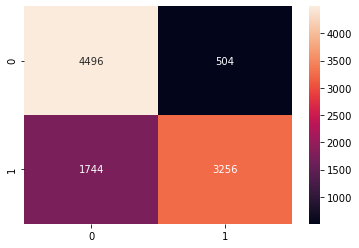

In [44]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

### CNN-LSTM

In [45]:
input_dim=X_train_glove.shape
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',input_shape=(100,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))    
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC'])

In [46]:
input_dim

(40000, 100)

In [47]:
model.fit(X_train_glove, y_train, batch_size=64, 
          epochs=20, verbose=1, 
          validation_data=(X_test_glove, y_test))

Epoch 1/20
625/625 [==============================] - 15s 22ms/step - loss: 0.6591 - accuracy: 0.5922 - auc: 0.6417 - val_loss: 0.5795 - val_accuracy: 0.6984 - val_auc: 0.7729
Epoch 2/20
625/625 [==============================] - 15s 24ms/step - loss: 0.5806 - accuracy: 0.6984 - auc: 0.7633 - val_loss: 0.5322 - val_accuracy: 0.7413 - val_auc: 0.8177
Epoch 3/20
625/625 [==============================] - 15s 24ms/step - loss: 0.5445 - accuracy: 0.7264 - auc: 0.7992 - val_loss: 0.5245 - val_accuracy: 0.7404 - val_auc: 0.8348
Epoch 4/20
625/625 [==============================] - 15s 24ms/step - loss: 0.5258 - accuracy: 0.7411 - auc: 0.8156 - val_loss: 0.5038 - val_accuracy: 0.7575 - val_auc: 0.8442
Epoch 5/20
625/625 [==============================] - 15s 24ms/step - loss: 0.5131 - accuracy: 0.7507 - auc: 0.8264 - val_loss: 0.4833 - val_accuracy: 0.7688 - val_auc: 0.8515
Epoch 6/20
625/625 [==============================] - 15s 23ms/step - loss: 0.5062 - accuracy: 0.7539 - auc: 0.8316 - va

In [48]:
y_pred = model.predict(X_test_glove)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80      5000
           1       0.82      0.74      0.78      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [49]:
res = tf.math.confusion_matrix(y_test,y_pred)

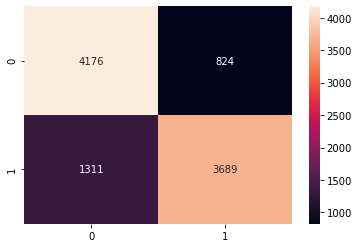

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

### Text Normalization

In [51]:
from nltk.tokenize.toktok import ToktokTokenizer
#Tokenization of text
tokenizer=ToktokTokenizer()

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [52]:
#Remove html strips and noise text
from bs4 import BeautifulSoup

#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
dataset['clean_review']=dataset['clean_review'].apply(denoise_text)

In [53]:
#Remove Special Characters

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on review column
dataset['clean_review']=dataset['clean_review'].apply(remove_special_characters)

In [54]:
#Text Stemming
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on review column
dataset['clean_review']=dataset['clean_review'].apply(simple_stemmer)

In [55]:
#Remove Stopwords
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
dataset['clean_review']=dataset['clean_review'].apply(remove_stopwords)

{'won', 'below', "weren't", 'your', "she's", 'haven', 't', 'you', 'how', "that'll", 'about', 'll', 'o', 'mightn', "haven't", 'we', 'doesn', 'between', 'the', "wasn't", 'so', "mightn't", "needn't", 'why', 'with', 've', "don't", 'until', 'do', "you'll", "isn't", 'when', 'all', 'to', 'they', 'are', 'for', 'my', 'needn', 'too', 'should', 'ourselves', 'does', 'wouldn', 'this', 'before', 'i', 's', "didn't", 'out', 'it', 'few', 'nor', "won't", 'theirs', 'them', 'been', "you've", 'doing', 'isn', 'here', 'some', 'very', 'once', 'that', 'is', 'myself', 'above', 'further', 'can', 'a', 'shan', 'ours', 'other', 'has', 'himself', 'our', 'd', 'by', 'which', "couldn't", 'just', 'be', 'did', 'yourself', 'couldn', 'at', 'ma', 'whom', 'there', 'on', 'each', "it's", 'such', 'mustn', 'now', 'aren', 'during', 'after', "you'd", 'these', 'or', 'having', 'both', 'only', 'don', 'were', 'his', 'down', 'didn', "mustn't", 'what', 'he', 'will', 'ain', 'an', 'again', 'through', 'then', 'where', 'yours', 'him', 'your

In [56]:
dataset.head()

,review,sentiment,text_length,clean_review
0,One of the other reviewers has mentioned that ...,positive,1761,one review ha mention watch 1 Oz episod youll ...
1,A wonderful little production. <br /><br />The...,positive,998,wonder littl product film techniqu veri unassu...
2,I thought this was a wonderful way to spend ti...,positive,926,thought thi wa wonder way spend time hot summe...
3,Basically there's a family where a little boy ...,negative,748,basic famili littl boy jake think zombi hi clo...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1317,petter mattei love time money visual stun film...


In [57]:
#split normalized dataset
X_train_norm = dataset['clean_review'][:40000]
X_train_norm.head()

0    one review ha mention watch 1 Oz episod youll ...
1    wonder littl product film techniqu veri unassu...
2    thought thi wa wonder way spend time hot summe...
3    basic famili littl boy jake think zombi hi clo...
4    petter mattei love time money visual stun film...
Name: clean_review, dtype: object

In [58]:
#split normalized dataset
X_test_norm=dataset['clean_review'][40000:]
X_test_norm.head()

40000    first want say lean liber polit scale found mo...
40001    wa excit see sitcom would hope repres indian c...
40002    look cover read stuff entir differ type movi c...
40003    like mani count appear denni hopper make thi c...
40004    thi movi wa tv day didnt enjoy first georg jun...
Name: clean_review, dtype: object

In [59]:
X_test_norm.shape

(10000,)

### Bags of Words Model

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

# Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

# Transformed train reviews
cv_train_reviews=cv.fit_transform(X_train_norm)

# Transformed test reviews
cv_test_reviews=cv.transform(X_test_norm)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (40000, 6208748)
BOW_cv_test: (10000, 6208748)


### Term Frequency-Inverse Document Frequency Model (TFIDF)

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TFIDF vectorizer
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

# Transformed train reviews
tv_train_reviews=tv.fit_transform(X_train_norm)

# Transformed test reviews
tv_test_reviews=tv.transform(X_test_norm)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6208748)
Tfidf_test: (10000, 6208748)


#### Label Sentiment Text

In [62]:
from sklearn.preprocessing import LabelBinarizer

# Labeb the sentient data
lb=LabelBinarizer()

# Transform sentiment data
sentiment_data=lb.fit_transform(dataset['sentiment'])
print(sentiment_data.shape)

(50000, 1)


#### Train/test Split Sentiment Data

In [63]:
# Split the sentiment data

train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
# print(train_sentiments)
# print(test_sentiments)

### Modeling-Logistic Regression on BOW and TFIDF

In [64]:
from sklearn.linear_model import LogisticRegression

# Train the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

#Fit the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)

#Fit the model for TFIDF features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

/Users/serenayang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


/Users/serenayang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(C=1, max_iter=500, random_state=42)


In [65]:
# Predict the model for BOW
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)

[0 0 0 ... 0 1 1]


In [66]:
# Predict the model for TFIDF
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]


In [67]:
# Accuracy score for BOW
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.751


In [68]:
# Accuracy score for TFIDF
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_tfidf_score : 0.7498


In [69]:
#Classification report for BOW
lr_bow_report=classification_report(test_sentiments,lr_bow_predict,target_names=['Positive','Negative'])
print(lr_bow_report)

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [70]:
#Classification report for TFIDF
lr_tfidf_report=classification_report(test_sentiments,lr_tfidf_predict,target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [71]:
# Confusion Matrix for BOW
cm_bow=confusion_matrix(test_sentiments,lr_bow_predict,labels=[1,0])
print("Confusion Matrix for BOW: \n", cm_bow)

Confusion Matrix for BOW: 
 [[3766 1241]
 [1249 3744]]


In [72]:
# Confusion Matrix for TFIDF
cm_tfidf=confusion_matrix(test_sentiments,lr_tfidf_predict,labels=[1,0])
print("Confusion Matrix for TFIDF: \n",cm_tfidf)

Confusion Matrix for TFIDF: 
 [[3661 1346]
 [1156 3837]]


In [73]:
# AUC
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, lr_tfidf_predict, pos_label=1)
metrics.auc(fpr, tpr)

0.749826109659175

In [74]:
fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, lr_bow_predict, pos_label=1)
metrics.auc(fpr, tpr)

0.7509983919568481

### Modeling-Stochastic Gradient Descent/Linear Support Vector Machines on BOW and TFIDF

In [75]:
from sklearn.linear_model import SGDClassifier
# Train the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)

# Fit the svm for bag of words
svm_bow=svm.fit(cv_train_reviews,train_sentiments)
print(svm_bow)

# FIt the svm for TDIDF features
svm_tfidf=svm.fit(tv_train_reviews,train_sentiments)
print(svm_tfidf)

/Users/serenayang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


In [76]:
# Predict the model for BOW
svm_bow_predict=svm.predict(cv_test_reviews)
print(svm_bow_predict)

[1 1 0 ... 1 1 1]


In [77]:
# Predict the model for TFIDF
svm_tfidf_predict=svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 1 ... 1 1 1]


In [78]:
# Classification report for BOW
svm_bow_report=classification_report(test_sentiments,svm_bow_predict,target_names=['Positive','Negative'])
print(svm_bow_report)

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000



In [79]:
# Classification report for TFIDF
svm_tfidf_report=classification_report(test_sentiments,svm_tfidf_predict,target_names=['Positive','Negative'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



In [80]:
# Confusion Matrix for BOW
cm_bow=confusion_matrix(test_sentiments,svm_bow_predict,labels=[1,0])
print("Confusion Matrix for BOW: \n", cm_bow)

Confusion Matrix for BOW: 
 [[4948   59]
 [4113  880]]


In [81]:
# Confusion Matrix for TFIDF
cm_tfidf=confusion_matrix(test_sentiments,svm_tfidf_predict,labels=[1,0])
print("Confusion Matrix for TFIDF: \n", cm_tfidf)

Confusion Matrix for TFIDF: 
 [[5007    0]
 [4888  105]]


In [82]:
# AUC
fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, svm_tfidf_predict, pos_label=1)
metrics.auc(fpr, tpr)

0.5105147206088524

In [83]:
fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, svm_bow_predict, pos_label=1)
metrics.auc(fpr, tpr)

0.5822316211739775

### Modeling-Multinomial Naive Bayes for BOW and TFIDF

In [84]:
from sklearn.naive_bayes import MultinomialNB

# Train the multinomial naive bayes model
mnb=MultinomialNB()

# Fit the svm for BOW
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

# Fit the svm for TFIDF
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

MultinomialNB()


/Users/serenayang/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


MultinomialNB()


In [85]:
# Predict the model for BOW
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

[0 0 0 ... 0 1 1]


In [86]:
# Predict the model for TFIDF
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]


In [87]:
# Accuracy score for BOW
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

mnb_bow_score : 0.7507


In [88]:
# Accuracy score for TFIDF
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_tfidf_score : 0.7507


In [89]:
#Classification report for BOW
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [90]:
#Classification report for TFIDF
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [91]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print("Confusion Matrix for BOW: \n", cm_bow)

Confusion Matrix for BOW: 
 [[3733 1274]
 [1219 3774]]


In [92]:
#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print("Confusion Matrix for TFIDF: \n", cm_tfidf)

Confusion Matrix for TFIDF: 
 [[3727 1280]
 [1213 3780]]


In [93]:
# AUC
fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, mnb_tfidf_predict, pos_label=1)
metrics.auc(fpr, tpr)

0.7507088913894272

In [94]:
fpr, tpr, thresholds = metrics.roc_curve(test_sentiments, mnb_bow_predict, pos_label=1)
metrics.auc(fpr, tpr)

0.7507072113861344

### Wordcloud

In [95]:
import sys
!{sys.executable} -m pip install textblob
from textblob import TextBlob
from textblob import Word

<function matplotlib.pyplot.show(close=None, block=None)>

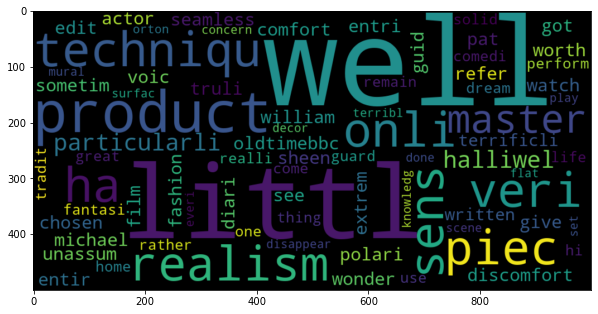

In [96]:
from textblob import TextBlob
from textblob import Word

# Word cloud for positive review words
plt.figure(figsize=(10,10))
positive_text=X_train_norm[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

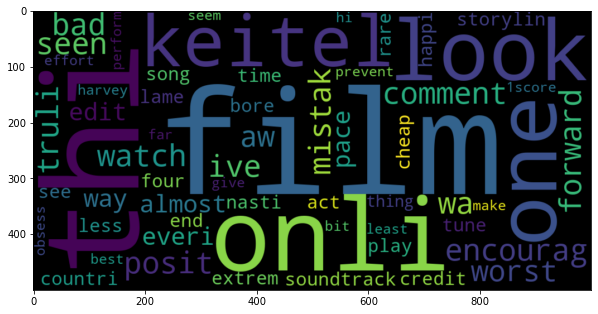

In [97]:
# Word cloud for negative review words
plt.figure(figsize=(10,10))
negative_text=X_train_norm[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show

### ---------------------------------------------------------------------------------------------------

### Run this after stage 2, after get data from web crawler

#### Using sentiment analysis model identify reviews

In [98]:
dataset_review = pd.read_csv('/Users/serenayang/Desktop/Group 3_Capstone Project/data/reviews_top.csv')

In [99]:
dataset_review.head()

,Unnamed: 0,Movie_title,user_name,rating_score,rating_time,num_helpful,review
0,0,0,0,0.0,0,0.00,0
1,0,Once Upon a Time... In Hollywood,TheLittleSongbird,9.0,2019-12-05,0.40,'Once Upon a Time in Hollywood' sounded like i...
2,1,Once Upon a Time... In Hollywood,bkoganbing,9.0,2019-07-27,0.50,Quentin Tarantino has given us a masterpiece w...
3,2,Once Upon a Time... In Hollywood,Leofwine_draca,8.0,2020-01-11,0.44,ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...
4,3,Once Upon a Time... In Hollywood,SnoopyStyle,7.0,2019-11-26,0.43,It's 1969 Hollywood. Rick Dalton (Leonardo DiC...


In [100]:
dataset_review = dataset_review.loc[1: , :]
dataset_review.head()

,Unnamed: 0,Movie_title,user_name,rating_score,rating_time,num_helpful,review
1,0,Once Upon a Time... In Hollywood,TheLittleSongbird,9.0,2019-12-05,0.40,'Once Upon a Time in Hollywood' sounded like i...
2,1,Once Upon a Time... In Hollywood,bkoganbing,9.0,2019-07-27,0.50,Quentin Tarantino has given us a masterpiece w...
3,2,Once Upon a Time... In Hollywood,Leofwine_draca,8.0,2020-01-11,0.44,ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...
4,3,Once Upon a Time... In Hollywood,SnoopyStyle,7.0,2019-11-26,0.43,It's 1969 Hollywood. Rick Dalton (Leonardo DiC...
5,4,Once Upon a Time... In Hollywood,Hitchcoc,8.0,2020-08-07,0.54,I don't know what to say about the plot. It me...


In [101]:
dataset_review.shape

(577772, 7)

In [102]:
dataset_review.drop(['Unnamed: 0'], axis=1, inplace=True)

In [103]:
dataset_review.head()

,Movie_title,user_name,rating_score,rating_time,num_helpful,review
1,Once Upon a Time... In Hollywood,TheLittleSongbird,9.0,2019-12-05,0.40,'Once Upon a Time in Hollywood' sounded like i...
2,Once Upon a Time... In Hollywood,bkoganbing,9.0,2019-07-27,0.50,Quentin Tarantino has given us a masterpiece w...
3,Once Upon a Time... In Hollywood,Leofwine_draca,8.0,2020-01-11,0.44,ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...
4,Once Upon a Time... In Hollywood,SnoopyStyle,7.0,2019-11-26,0.43,It's 1969 Hollywood. Rick Dalton (Leonardo DiC...
5,Once Upon a Time... In Hollywood,Hitchcoc,8.0,2020-08-07,0.54,I don't know what to say about the plot. It me...


In [104]:
review_df = dataset_review["review"]
review_df.head()

1    'Once Upon a Time in Hollywood' sounded like i...
2    Quentin Tarantino has given us a masterpiece w...
3    ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...
4    It's 1969 Hollywood. Rick Dalton (Leonardo DiC...
5    I don't know what to say about the plot. It me...
Name: review, dtype: object

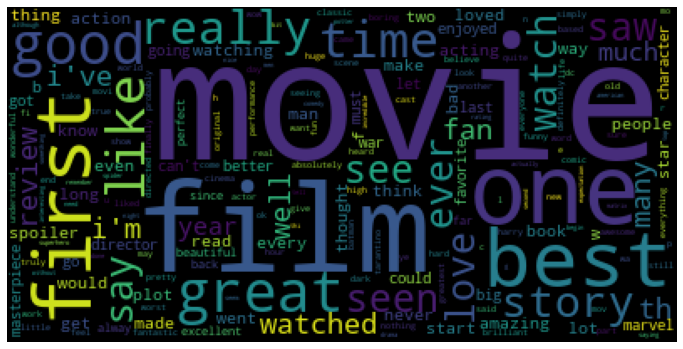

In [105]:
dataset_review['clean_review'] = dataset_review['review'].apply(clean_text)

text = dataset_review['clean_review'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [106]:
reviews_IMDb = dataset_review[['clean_review']]
reviews_IMDb.head()

,clean_review
1,'Once Upon a Time in Hollywood' sounded like i...
2,Quentin Tarantino has given us a masterpiece w...
3,ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...
4,It's 1969 Hollywood. Rick Dalton (Leonardo DiC...
5,I don't know what to say about the plot. It me...


In [107]:
review_glove = get_vector(reviews_IMDb, "clean_review")

<ipython-input-26-7216fb759116>:8: RuntimeWarning: invalid value encountered in true_divide
  return encoded / doclen


In [108]:
len(review_glove) #List

577772

In [109]:
df_review = pd.DataFrame(review_glove)

In [110]:
df_review.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.096251,0.137177,0.371485,-0.282868,0.051659,0.179730,-0.125950,0.147953,-0.172327,0.007402,...,0.001136,-0.169468,-0.158091,0.146904,-0.480755,-0.006344,-0.319610,-0.368489,0.432293,0.212015
1,-0.020818,0.105819,0.311828,-0.276150,0.065479,0.183188,-0.079677,0.189268,-0.230290,0.045836,...,-0.031837,-0.168610,-0.120034,0.190209,-0.519635,0.007062,-0.266880,-0.270508,0.388903,0.166730
2,-0.045944,0.159410,0.356255,-0.225388,0.130945,0.191743,-0.157302,0.137584,-0.136620,0.092934,...,0.012454,-0.093257,-0.148396,0.170794,-0.419528,-0.042927,-0.288127,-0.345808,0.408103,0.221498
3,-0.048197,0.094284,0.367352,-0.333739,-0.025649,0.127651,-0.097397,0.170803,-0.078642,-0.017267,...,-0.032755,-0.195929,-0.097880,0.155227,-0.405841,-0.024163,-0.222915,-0.341680,0.379652,0.121215
4,-0.043042,0.139946,0.378436,-0.291314,-0.118306,0.190299,-0.134538,0.167515,-0.048404,-0.028777,...,-0.099518,-0.193422,-0.080113,0.150465,-0.465439,-0.006884,-0.304653,-0.363007,0.413983,0.279980


In [111]:
y_review = model_DNN_GloVe.predict(df_review)

In [112]:
y_review_1 = np.where(y_review > 0.5, 1, -1)

In [113]:
dataset_review_1 = dataset_review

In [114]:
dataset_review_1["sentiment_key"] = y_review_1
dataset_review_1.head()

,Movie_title,user_name,rating_score,rating_time,num_helpful,review,clean_review,sentiment_key
1,Once Upon a Time... In Hollywood,TheLittleSongbird,9.0,2019-12-05,0.40,'Once Upon a Time in Hollywood' sounded like i...,'Once Upon a Time in Hollywood' sounded like i...,1
2,Once Upon a Time... In Hollywood,bkoganbing,9.0,2019-07-27,0.50,Quentin Tarantino has given us a masterpiece w...,Quentin Tarantino has given us a masterpiece w...,1
3,Once Upon a Time... In Hollywood,Leofwine_draca,8.0,2020-01-11,0.44,ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...,ONCE UPON A TIME... IN HOLLYWOOD is Tarantino'...,1
4,Once Upon a Time... In Hollywood,SnoopyStyle,7.0,2019-11-26,0.43,It's 1969 Hollywood. Rick Dalton (Leonardo DiC...,It's 1969 Hollywood. Rick Dalton (Leonardo DiC...,-1
5,Once Upon a Time... In Hollywood,Hitchcoc,8.0,2020-08-07,0.54,I don't know what to say about the plot. It me...,I don't know what to say about the plot. It me...,1


In [117]:
dataset_review_1.to_csv('/Users/serenayang/Desktop/Group 3_Capstone Project/data/dataset_review_1.csv') 